In [7]:
import pandas as pd
import numpy as np
import sqlite3
from huggingface_hub import login, logout
from datasets import load_dataset
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from util.util_data import special_encode, makeRegex
from util.util_kwrds import class_keywords, extract_keywords
import torch
import logging
logging.getLogger("pytorch_pretrained_bert.tokenization").setLevel(logging.ERROR)

# **1. Clinical Trial Announcements**

In [5]:
engine = sqlite3.connect('./src/data.db')
catalyst = pd.read_sql('SELECT * FROM catalysts', engine)
catalyst.head()

,ticker,disease,stage,date,catalyst
0,SNSE,Various cancers,Phase 1,2023-11-04 00:00:00,Phase 1 safety data reported that a total of 1...
1,REGN,Various cancers,Phase 1,2023-11-04 00:00:00,Phase 1 safety data reported that a total of 1...
2,AUPH,Lupus Nephritis,Phase 3,2023-11-03 00:00:00,Phase 3 data from ASN reported that treated pa...
3,IPHA,Mycosis Fungoides,Phase 2,2023-11-03 00:00:00,Phase 2 data from ASH abstract reported that t...
4,HOWL,Solid Tumors,Phase 1b,2023-11-03 00:00:00,Phase 1/1b preliminary data provided compellin...


In [ ]:
catalyst['stage'].value_counts().plot(kind='barh')

## **1.1 Initial Rule-Based Labeling**

In [ ]:
dove = makeRegex(["approv", "meet", "show", "reach"])
hawk = makeRegex(["halt", "fail", "no diff"]) +\
    makeRegex(dove, neg=True)
labs_init = catalyst['catalyst'].apply(special_encode,
                                       bull_words=dove,
                                       bear_words=hawk)

In [ ]:
labs_init.value_counts().plot(kind='barh')

## **1.2 Keyword Generation with BioBERT**

In [ ]:
#  NOTE: change if needed
#  "dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0" BioBERT
#  "roberta-large-mnli" RoBERTa Large
filtered_words = [i for i in stopwords.words('english') if i not in  ["no", "not"]]
model = SentenceTransformer('dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0') # fine-tuned bioBERT
key_words = catalyst['catalyst'].apply(extract_keywords, stop_words=filtered_words, model=model) # generate keywords

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0")
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=torch.device('mps'), framework='pt', truncation=True)

In [ ]:
type(classifier)

In [ ]:
class_kwrds = class_keywords(classifier=classifier, kwrds=key_words) # sentiment analysis on generated keywords

In [169]:
# compared outputs from BioBERT or RoBERTa to improve our keyword selection to build ground truth labels
bull_words = [
    "preserv", "eval", "improv", "show", "meet", "met",\
        "approv", "present", "observ", "achiev", "attain",\
            "favor", "toler", "treat", "reduc", "reach"
            ]
bear_words = ["toxic", "halt", "fail"]
bear_words = makeRegex(bull_words, neg=True) + makeRegex(bear_words)
bull_words = makeRegex(bull_words)
labs_new = catalyst['catalyst'].apply(special_encode,
                                               bull_words=bull_words,
                                               bear_words=bear_words)

<Axes: ylabel='label'>

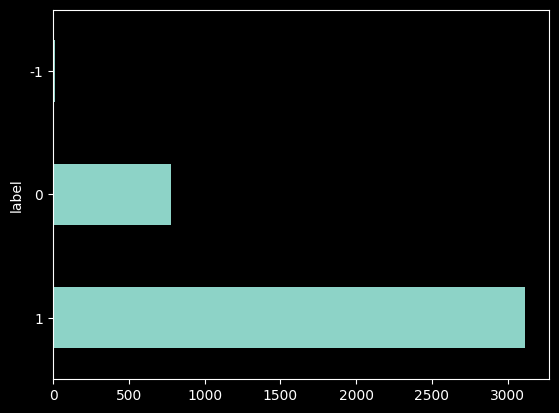

In [207]:
labs_new.value_counts().plot(kind='barh')

# Archives

In [209]:
df = catalyst.copy(deep=True).sort_values(by=['date']).reset_index(drop=True)
df.head()


,ticker,disease,stage,date,catalyst,label
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009.",1
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010.",0
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011.",1
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1


In [210]:
train_size = 0.8
row_len = int(train_size * df.shape[0])
train = df.iloc[:row_len, :]
test = df.iloc[row_len:, :]
print(train.shape)
print(test.shape)
print(catalyst.shape)


(3128, 6)
(783, 6)
(3911, 6)


In [211]:
train


,ticker,disease,stage,date,catalyst,label
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009.",1
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010.",0
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011.",1
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
...,...,...,...,...,...,...
3123,ALNY,Hepatitis B (HBV),Phase 2,2023-06-24 00:00:00,Phase 2 24 or 48 weeks plus up to 48 weeks of ...,1
3124,RLYB,Fetal and neonatal alloimmune thrombocytopenia...,Phase 1b,2023-06-24 00:00:00,Phase 1b data presented at ISTH showed that su...,1
3125,VIR,Hepatitis B,Phase 1,2023-06-24 00:00:00,Phase 1 data showed that treatment has a short...,1
3126,TAK,Alpha-1 Liver Disease,Phase 2,2023-06-24 00:00:00,Phase 2 data presented at EASL showed that at ...,1


In [212]:
train.to_csv("train.csv", index=0)
test.to_csv("test.csv", index=0)
catalyst.to_csv("catalyst.csv", index=0)


In [214]:
login()


In [215]:
dataset = load_dataset("roymgabriel/BioPharma")
dataset


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 3128
    })
    test: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 783
    })
})

In [216]:
logout()


Successfully logged out.
